Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 23887703.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 1454821.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 10262428.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 6308122.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5] | D Loss: 0.1608 | G Loss: 1.7897
Epoch [2/5] | D Loss: 0.4577 | G Loss: 1.1085
Epoch [3/5] | D Loss: 0.2658 | G Loss: 1.8734
Epoch [4/5] | D Loss: 0.0920 | G Loss: 3.1087
Epoch [5/5] | D Loss: 0.0267 | G Loss: 3.7863


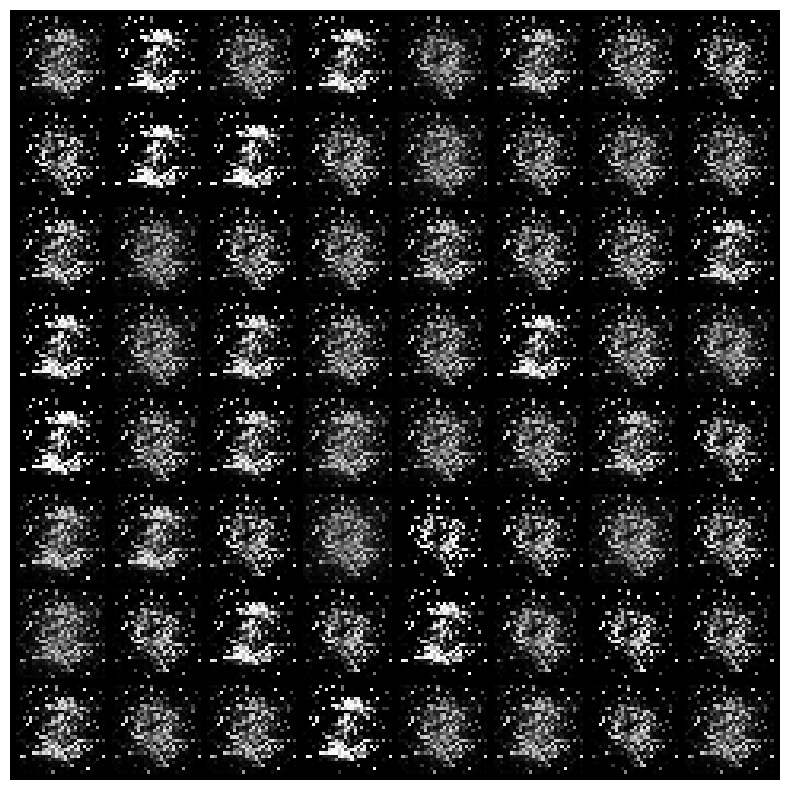

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os

# Define a smaller Generator model for quick training
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define a smaller Discriminator model for quick training
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Training parameters
latent_dim = 64  # Smaller latent dimension for quicker training
img_size = 28 * 28  # For MNIST, 28x28 images
batch_size = 32
epochs = 5  # Reduced number of epochs for quick training

# Load Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, img_size).to(device)
discriminator = Discriminator(img_size).to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)
adversarial_loss = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Prepare real and fake data
        real_imgs = imgs.view(imgs.size(0), -1).to(device)
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        generated_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(generated_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate and save synthetic images
os.makedirs("synthetic_data", exist_ok=True)
z = torch.randn(64, latent_dim).to(device)
with torch.no_grad():
    generated_imgs = generator(z).view(-1, 1, 28, 28)
    save_image(generated_imgs, "synthetic_data/synthetic_images.png", nrow=8, normalize=True)

# Display generated images
grid = make_grid(generated_imgs, nrow=8, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os

# Generator model for DCGAN
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator model for DCGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)



In [9]:
# Training parameters
latent_dim = 64
batch_size = 32
epochs = 3  # Train for a limited number of epochs to keep training short

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [10]:
# Initialize models and optimizers
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


In [11]:
# Training loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # Create labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        generated_imgs = generator(z)
        g_loss = criterion(discriminator(generated_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

print("Training complete!")


Epoch [1/3] | D Loss: 0.2842 | G Loss: 1.9534
Epoch [2/3] | D Loss: 0.2050 | G Loss: 1.6831
Epoch [3/3] | D Loss: 0.2653 | G Loss: 2.0798
Training complete!


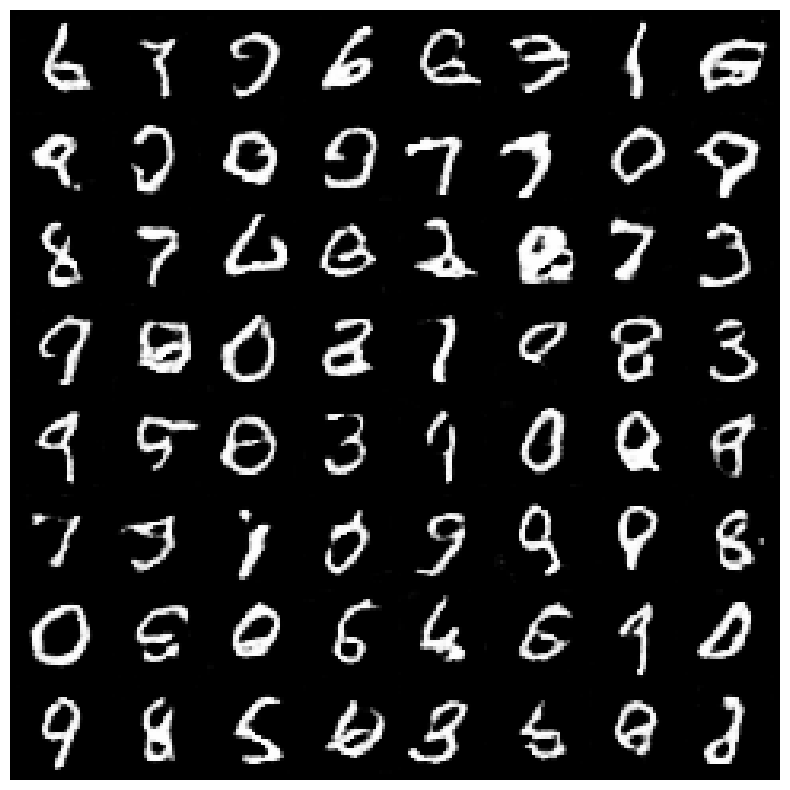

In [12]:
# Generate synthetic images
os.makedirs("synthetic_data", exist_ok=True)
z = torch.randn(64, latent_dim, 1, 1, device=device)
with torch.no_grad():
    generated_imgs = generator(z).cpu()

# Save and display generated images
save_image(generated_imgs, "synthetic_data/synthetic_images.png", nrow=8, normalize=True)
grid = make_grid(generated_imgs, nrow=8, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis('off')
plt.show()
